In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from seismic_purifier.config import BATCH_SIZE
from seismic_purifier.representation_learning_models import (
    RepresentationLearningSingleAutoencoder,
    RepresentationLearningDenoisingSingleAutoencoder,
    RepresentationLearningMultipleAutoencoder
)
from seismic_purifier.classifier_models import (
    ClassifierAutocovariance, 
    ClassifierAugmentedAutoencoder, 
    ClassifierMultipleAutoencoder
)
import matplotlib.pyplot as plt

2025-02-10 19:35:56.015286: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 19:35:56.046819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 19:35:56.046846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 19:35:56.046866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 19:35:56.053421: I tensorflow/core/platform/cpu_feature_g

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [24]:
# ============================
# 1. Configuration
# ============================

# Paths to your data
TEST_DATA_PATH = 'data/X_test_1280sample.npy'  # Replace with your actual path
TEST_LABEL_PATH = 'data/Y_test_1280sample.npy'  # Replace with your actual path

# Paths to your model
MODEL_PATH = 'checkpoints/representation_cross_covariances.h5'

In [25]:
# ============================
# 2. Data loading
# ============================
X_test = np.load(TEST_DATA_PATH)
print(f"Test data shape: {X_test.shape}")

Y_test = np.load(TEST_LABEL_PATH)  # Expected shape: (num_samples)
print(f"Test label shape: {Y_test.shape}")

Test data shape: (1280, 3000, 3)
Test label shape: (1280,)


In [26]:
# ============================
# 3. Representation Learning Model Instantiation
# ============================

# Choose the model you want to train
# For example, using RepresentationLearningSingleAutoencoder
#model = RepresentationLearningSingleAutoencoder(
#    name="rep_learning_autoencoder"
#)

# Alternatively, you can choose other models:
# model = RepresentationLearningDenoisingSingleAutoencoder(
#     name="rep_learning_denoising_autoencoder",
#     input_noise_std=1e-6,
#     denoising_noise_std=2e-1
# )
model = RepresentationLearningMultipleAutoencoder(
     name="rep_learning_autoencoder_ensemble",
     input_noise_std=1e-6,
     eps=1e-27
)

In [27]:
# ============================
# 4. Model Compilation
# ============================
model.compile()
model(X_test)
model.load_weights(MODEL_PATH)

In [28]:
# ============================
# 5. Classifier Model Instantiation
# ============================

# Choose the model for classification. This is just for convenience, these models are actually wrappers around
#representation learning models.
# For example, using RepresentationLearningSingleAutoencoder
# model_classifier = ClassifierAutocovariance(model)

# Alternatively, you can choose other wrappers. 
# model_classifier = ClassifierAugmentedAutoencoder(model)
model_classifier = ClassifierMultipleAutoencoder(model)

"""Note: One should be careful about the compatibility of the classifier wrappers with the models. RepresentationLearningSingleAutoencoder and RepresentationLearningDenoising
Autoencoder are compatible with ClassifierAutocovariance, ClassifierAugmentedAutoencoder. However, RepresentationLearningMultipleAutoencoder is only compatible with 
ClassifierMultipleAutoencoder. """

'Note: One should be careful about the compatibility of the classifier wrappers with the models. RepresentationLearningSingleAutoencoder and RepresentationLearningDenoising\nAutoencoder are compatible with ClassifierAutocovariance, ClassifierAugmentedAutoencoder. However, RepresentationLearningMultipleAutoencoder is only compatible with \nClassifierMultipleAutoencoder. '

In [29]:
# ============================
# 6. Obtain earthquake probabilities
# ============================
earthquake_scores = model_classifier(X_test)

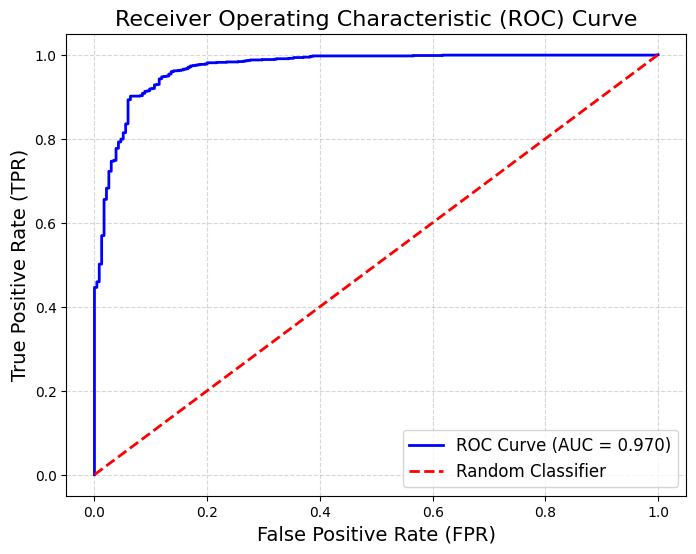

In [30]:
# ============================
# 7. Plot ROC curve.
# ============================
fpr, tpr, __ = roc_curve(Y_test, earthquake_scores)
auc_score = roc_auc_score(y_true=Y_test, y_score=earthquake_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [31]:
auc_score

0.9697098646034815